# nlp100 chapter5

Try:http://www.cl.ecei.tohoku.ac.jp/nlp100

In [1]:
%matplotlib inline
import os
import sys
import re
import MeCab
import ngram
import numpy as np
import pandas as pd
import pydot
from PIL import Image
import itertools
import matplotlib.pyplot as plt
os.chdir('../../nnnnishi/nlp-100knock')

## 40. 係り受け解析結果の読み込み（形態素）
reference:http://taku910.github.io/cabocha/

In [2]:
import CaboCha

c = CaboCha.Parser()

with open('data/neko.txt.cabocha', 'w') as writer:
    with open('data/neko.txt') as reader:
        for line in reader:
            tree = c.parse(line)
            if len(line) > 1: 
                writer.write(tree.toString(CaboCha.FORMAT_LATTICE))

In [3]:
class Morph(object):
    def __init__(self, l):
        l = re.sub(r'\t', ',', l)
        token = re.split(',', l)
        if len(token) > 7:
            self.surface = token[0]
            self.base = token[7]
            self.pos = token[1]
            self.pos1 = token[2]
        else:
            self.surface = token[0]
            self.base = ''
            self.pos = ''
            self.pos1 = '' 


f = os.path.join('data', 'neko.txt.cabocha')

ms = []
mss = []
with open(f) as reader:
    for line in reader:
        if re.search('EOS', line):
            mss.append(ms)
            ms = []
            continue
        if re.search(r'^\*',line):
            continue
        m = Morph(line)
        ms.append(m)
        
for i in range(len(mss[2])):
    print(mss[2][i].__dict__)

{'surface': '名前', 'pos': '名詞', 'pos1': '一般', 'base': '名前'}
{'surface': 'は', 'pos': '助詞', 'pos1': '係助詞', 'base': 'は'}
{'surface': 'まだ', 'pos': '副詞', 'pos1': '助詞類接続', 'base': 'まだ'}
{'surface': '無い', 'pos': '形容詞', 'pos1': '自立', 'base': '無い'}
{'surface': '。', 'pos': '記号', 'pos1': '句点', 'base': '。'}


## 41. 係り受け解析結果の読み込み（文節・係り受け）

In [4]:
class Morph(object):
    def __init__(self, l):
        l = re.sub(r'\t', ',', l)
        t = re.split(',', l)
        if len(t) > 7:
            self.surface = t[0]
            self.base = t[7]
            self.pos = t[1]
            self.pos1 = t[2]
        else:
            self.surface = t[0]
            self.base = ''
            self.pos = ''
            self.pos1 = '' 

            
class Chunk:
    def __init__(self):
        self.morphs = []
        self.dst = 0
        self.srcs = []


d = {}
sentence_num = 0
chunk_num = -1

with open(f) as reader:
    for line in reader:
        if "EOS" == line[0:3]:
            chunk_num = -1
            for i in d[sentence_num]:
                if d[sentence_num][i].dst != "-1":
                    d[sentence_num][int(d[sentence_num][i].dst)].srcs.append(i)
            sentence_num += 1
            d[sentence_num] = {}
        elif "*" == line[0:1]:
            token = line.split(' ')
            chunk_num += 1
            d.setdefault(sentence_num, {})
            d[sentence_num][chunk_num] = Chunk()
            d[sentence_num][chunk_num].dst = token[2][:-1]
        else:
            d[sentence_num][chunk_num].morphs.append(Morph(line))

N = 7
print('文番号:', N+1)
for i in d[N]:
    txt = []
    for j in d[N][i].morphs:
        txt.append(j.surface)
    print('文節番号:', i, '文節の文字列:', ''.join(txt), '係り先:', d[N][i].dst)

文番号: 8
文節番号: 0 文節の文字列: この 係り先: 1
文節番号: 1 文節の文字列: 書生というのは 係り先: 7
文節番号: 2 文節の文字列: 時々 係り先: 4
文節番号: 3 文節の文字列: 我々を 係り先: 4
文節番号: 4 文節の文字列: 捕えて 係り先: 5
文節番号: 5 文節の文字列: 煮て 係り先: 6
文節番号: 6 文節の文字列: 食うという 係り先: 7
文節番号: 7 文節の文字列: 話である。 係り先: -1


## 42. 係り元と係り先の文節の表示

In [5]:
d = {}
sentence_num = 0
chunk_num = -1

with open(f) as reader:
    for line in reader:
        if "EOS" == line[0:3]:
            chunk_num = -1
            for i in d[sentence_num]:
                if d[sentence_num][i].dst != "-1":
                    d[sentence_num][int(d[sentence_num][i].dst)].srcs.append(i)
            sentence_num += 1
            d[sentence_num] = {}
        elif "*" == line[0:1]:
            token = line.split(' ')
            chunk_num += 1
            d.setdefault(sentence_num, {})
            d[sentence_num][chunk_num] = Chunk()
            d[sentence_num][chunk_num].dst = token[2][:-1]
        elif Morph(line).pos == '記号':
            continue
        else:
            d[sentence_num][chunk_num].morphs.append(Morph(line))


for N in range(5):
    i2depend = {}
    i2w = {}
    for i in d[N]:
        txt = []
        for j in d[N][i].morphs:
            txt.append(j.surface)
        i2depend[i] = d[N][i].dst
        i2w[i] = ''.join(txt)
    
    for i in d[N]:
        if i2w[i] != '' and i2depend[i] != '-1':
            print(i2w[i]+'\t'+i2w[int(i2depend[i])])

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [6]:
for N in range(10):
    i2depend = {}
    i2w = {}
    i2existN = {}
    i2existV = {}
    for i in d[N]:
        txt = []
        i2existN[i] = 0
        i2existV[i] = 0
        for j in d[N][i].morphs:
            txt.append(j.surface)
            if j.pos == '名詞':
                i2existN[i] = 1
            if j.pos == '動詞':
                i2existV[i] = 1
        i2depend[i] = d[N][i].dst
        i2w[i] = ''.join(txt)
    
    for i in d[N]:
        if i2depend[i] != '-1':
            if i2existN[i] == 1 and i2existV[int(i2depend[i])]:
                print(i2w[i]+'\t'+i2w[int(i2depend[i])])

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである


## 44. 係り受け木の可視化

[['しかも', '種族であったそうだ'], ['あとで', '聞くと'], ['聞くと', '種族であったそうだ'], ['それは', '種族であったそうだ'], ['書生という', '人間中で'], ['人間中で', '種族であったそうだ'], ['一番', '獰悪な'], ['獰悪な', '種族であったそうだ']]


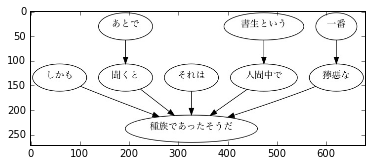

In [7]:
N = 6
edges = []
i2depend = {}
i2w = {}

for i in d[N]:
    txt = []
    for j in d[N][i].morphs:
        txt.append(j.surface)
    i2depend[i] = d[N][i].dst
    i2w[i] = ''.join(txt)
    
for i in d[N]:
    if i2w[i] != '' and i2depend[i] != '-1':
        edges.append([i2w[i], i2w[int(i2depend[i])]])
            
print(edges)

g=pydot.graph_from_edges(edges, directed=True)
g.write_jpeg('data/neko.jpg', prog='dot')
im = Image.open("data/neko.jpg")
im_list = np.asarray(im)
plt.imshow(im_list)
plt.show()

## 45. 動詞の格パターンの抽出

In [8]:
pattern = []
with open('data/45.tsv', 'w') as writer: 
    for N in range(len(d)):
        for i in range(len(d[N])):
            for j in range(len(d[N][i].morphs)):
                if d[N][i].morphs[j].pos == '動詞':
                    combination = []
                    combination.append(d[N][i].morphs[j].base)
                    for k in range(len(d[N])):
                        if int(d[N][k].dst) == i:
                            for l in range(len(d[N][k].morphs)):
                                if d[N][k].morphs[l].pos == '助詞':
                                    combination.append(d[N][k].morphs[l].surface)
                    if len(combination) > 1:
                        writer.write('\t'.join(combination)+'\n')
                        pattern.append([combination[0], ' '.join(sorted(combination[1:]))])
                break
                
df = pd.DataFrame(pattern, columns=['動詞', '助詞'])
df['count'] = 1
count_df = df.groupby(['動詞', '助詞']).sum().sort_values('count', ascending=False)
print(count_df.head())
suru_df = df[df['動詞']=='する'].groupby(['動詞', '助詞']).sum().sort_values('count', ascending=False)
print(suru_df.head())
miru_df = df[df['動詞']=='見る'].groupby(['動詞', '助詞']).sum().sort_values('count', ascending=False)
print(miru_df.head())
ataeru_df = df[df['動詞']=='与える'].groupby(['動詞', '助詞']).sum().sort_values('count', ascending=False)
print(ataeru_df.head())

       count
動詞 助詞       
云う と     565
思う と     249
する を     219
ある が     198
なる に     184
        count
動詞 助詞        
する を      219
   に       82
   に を     58
   と       47
   が       44
        count
動詞 助詞        
見る て      173
   を       94
   て て     21
   から      20
   て を     18
                     count
動詞  助詞                    
与える に を                  3
    て に は を              2
    か じゃあ て と は を        1
    か として を              1
    が て て と に は は を      1


## 46. 動詞の格フレーム情報の抽出

In [9]:
with open('data/46.tsv', 'w') as writer: 
    for N in range(len(d)):
        for i in range(len(d[N])):
            for j in range(len(d[N][i].morphs)):
                if d[N][i].morphs[j].pos == '動詞':
                    v = [d[N][i].morphs[j].base]
                    pp = []
                    pp_last = []
                    src = []
                    for k in range(len(d[N])):
                        if int(d[N][k].dst) == i:
                            sr = []
                            exist_pp = False
                            for l in range(len(d[N][k].morphs)):
                                if d[N][k].morphs[l].pos == '助詞':
                                    pp.append(d[N][k].morphs[l].surface)
                                    exist_pp = True
                                sr.append(d[N][k].morphs[l].surface)
                            if exist_pp:
                                src.append(''.join(sr))
                                pp_last.append(pp[-1])
                            
                    if len(v+pp) > 1:
                        sort_list = sorted([pp_last, src])
                        pp = ' '.join(sort_list[0])
                        src = ' '.join(sort_list[1])
                        writer.write('\t'.join(v + [pp, src])+'\n')
                        if N < 10:
                            print('\t'.join(v + [pp, src]))
                break

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
始める	ここで	で
見る	は を	吾輩は ものを
聞く	あとで	で
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
ある	が	感じが


## 47. 機能動詞構文のマイニング

In [10]:
with open('data/47.tsv', 'w') as writer: 
    for N in range(len(d)):
        for i in range(len(d[N])):
            for j in range(len(d[N][i].morphs)):
                if d[N][i].morphs[j].pos == '動詞':
                    v = [d[N][i].morphs[j].base]
                    pp = []
                    pp_last = []
                    src = []    
                    sahen_connect = ''
                    exist_sahen_plus_wo = False
                    for k in range(len(d[N])):
                        if int(d[N][k].dst) == i:
                            sr = []
                            exist_pp = False
                            exist_sahen_connect = False
                            exist_wo = False        
                            for l in range(len(d[N][k].morphs)):
                                if d[N][k].morphs[l].pos1 == 'サ変接続':
                                    exist_sahen_connect = True
                                    sahen_connect = d[N][k].morphs[l].surface
                                
                                if d[N][k].morphs[l].pos == '助詞':
                                    exist_pp = True
                                    if d[N][k].morphs[l].surface == 'を':
                                        exist_wo = True
                                        
                                if exist_pp and (not (exist_sahen_connect and exist_wo)):
                                    pp.append(d[N][k].morphs[l].surface)  
                                        
                                sr.append(d[N][k].morphs[l].surface)
                            
                            if exist_sahen_connect and exist_wo:
                                exist_sahen_plus_wo = True

                            if exist_pp and (not exist_sahen_connect):
                                src.append(''.join(sr))
                                pp_last.append(pp[-1])
                         
                    if len(v+pp) > 1 and exist_sahen_plus_wo:
                        sort_list = sorted([pp_last, src])
                        pp = ' '.join(sort_list[0])
                        src = ' '.join(sort_list[1])
                        writer.write('\t'.join([sahen_connect+'を'+v[0]] + [pp, src])+'\n')
                        if N < 100:
                            print('\t'.join([sahen_connect+'を'+v[0]] + [pp, src]))
                break

決心をする	こうと	と
返報をする	んで	偸んで
昼寝をする	が	彼が


In [11]:
df = pd.read_csv('data/47.tsv', delimiter='\t', header=None, names=['述語', '助詞', '文節'])
df['count'] = 1
df = df.groupby(by='述語').sum().sort_values(by='count',ascending=False)
df.head()

,count
述語,
返事をする,26
挨拶をする,19
話をする,10
喧嘩をする,7
真似をする,6


In [12]:
df = pd.read_csv('data/47.tsv', delimiter='\t', header=None, names=['述語', '助詞', '文節'])
df['count'] = 1
df = df.groupby(by=['述語','助詞']).sum().sort_values(by='count',ascending=False)
df.head()

,,count
述語,助詞,
返事をする,と,5
挨拶をする,から,3
喧嘩をする,と,3
返事をする,は と,3
同情を表する,と は て,2


## 48. 名詞から根へのパスの抽出

In [13]:
def return_path(sentence_num, chunk_num):
    path_list = []
    chunk_list = []
    exist_noun = False
    for i in range(len(d[sentence_num][chunk_num].morphs)):
        chunk_list.append(d[sentence_num][chunk_num].morphs[i].surface)
        if d[sentence_num][chunk_num].morphs[i].pos == '名詞':
            exist_noun = True
    path_list.append(''.join(chunk_list))
    next = int(d[sentence_num][chunk_num].dst)
    if next != -1 and exist_noun:        
        while next != -1:
            chunk_list = []
            for j in range(len(d[sentence_num][next].morphs)):
                chunk_list.append(d[sentence_num][next].morphs[j].surface)
            path_list.append(''.join(chunk_list))
            next = int(d[sentence_num][next].dst)
        print(' -> '.join(path_list))

d = {}
sentence_num = 0
chunk_num = -1

with open(f) as reader:
    for line in reader:
        if "EOS" == line[0:3]:
            chunk_num = -1
            for i in d[sentence_num]:
                if d[sentence_num][i].dst != "-1":
                    d[sentence_num][int(d[sentence_num][i].dst)].srcs.append(i)
            sentence_num += 1
            d[sentence_num] = {}
        elif "*" == line[0:1]:
            token = line.split(' ')
            chunk_num += 1
            d.setdefault(sentence_num, {})
            d[sentence_num][chunk_num] = Chunk()
            d[sentence_num][chunk_num].dst = token[2][:-1]
        else:
            d[sentence_num][chunk_num].morphs.append(Morph(line))

for N in range(len(d)):
    for i in range(len(d[N])):
        return_path(N, i)
    if N > 4: break

吾輩は -> 猫である。
名前は -> 無い。
　どこで -> 生れたか -> つかぬ。
見当が -> つかぬ。
何でも -> 薄暗い -> 所で -> 泣いて -> 記憶している。
所で -> 泣いて -> 記憶している。
ニャーニャー -> 泣いて -> 記憶している。
いた事だけは -> 記憶している。
吾輩は -> 見た。
ここで -> 始めて -> 人間という -> ものを -> 見た。
人間という -> ものを -> 見た。
ものを -> 見た。


## 49. 名詞間の係り受けパスの抽出

In [14]:
def search_noun(sentence_num):
    noun_list = []
    for i in range(len(d[sentence_num])):
        for j in range(len(d[sentence_num][i].morphs)):
            if d[sentence_num][i].morphs[j].pos == '名詞':
                noun_list.append(i)
    return noun_list


def check_XtoY(sentence_num, combi):
    z_list = []
    Xi = int(combi[0])
    Yi = int(combi[1])
    # X
    next = int(d[sentence_num][Xi].dst)
    z_list.append(next)    
    while next != -1:
        if next == Yi:
            return [True, next]
        next = int(d[sentence_num][next].dst)
        z_list.append(next)
    # Y
    next = int(d[sentence_num][Yi].dst) 
    while next != -1:
        if next in z_list:
            return [False, next]
        next = int(d[sentence_num][next].dst)
    return [False, -1]


def show_XtoY(sentence_num, combi):
    Xi = int(combi[0])
    Yi = int(combi[1])
    path_list = []
    chunk_list = []
    for i in range(len(d[sentence_num][Xi].morphs)):
        if d[sentence_num][Xi].morphs[i].pos == '名詞':
            chunk_list.append('X')
        else:
            chunk_list.append(d[sentence_num][Xi].morphs[i].surface)
    path_list.append(''.join(chunk_list))
    next = int(d[sentence_num][Xi].dst)      
    while next != -1:
        if next == Yi:
            path_list.append('Y')
            break
        else:
            chunk_list = []
            for j in range(len(d[sentence_num][next].morphs)):
                chunk_list.append(d[sentence_num][next].morphs[j].surface)
            path_list.append(''.join(chunk_list))
            next = int(d[sentence_num][next].dst)
    print(' -> '.join(path_list))
        
        
def show_XandYtoZ(sentence_num, combi ,Zi):
    path_list = []
    Xi = int(combi[0])
    Yi = int(combi[1])  
    # X -> Z
    small_path_list = []
    chunk_list = []
    for i in range(len(d[sentence_num][Xi].morphs)):
        if d[sentence_num][Xi].morphs[i].pos == '名詞':
            chunk_list.append('X')
        else:
            chunk_list.append(d[sentence_num][Xi].morphs[i].surface)
    small_path_list.append(''.join(chunk_list))
    next = int(d[sentence_num][Xi].dst)        

    while next != Zi:
        chunk_list = []
        for j in range(len(d[sentence_num][next].morphs)):
            chunk_list.append(d[sentence_num][next].morphs[j].surface)
        small_path_list.append(''.join(chunk_list))
        next = int(d[sentence_num][next].dst)
    
    if len(small_path_list) > 1:
        path_list.append(' -> '.join(small_path_list))
    else:
        path_list.append(small_path_list[0])

    # Y -> Z
    small_path_list = []
    chunk_list = []
    for i in range(len(d[sentence_num][Yi].morphs)):
        if d[sentence_num][Yi].morphs[i].pos == '名詞':
            chunk_list.append('Y')
        else:
            chunk_list.append(d[sentence_num][Yi].morphs[i].surface)
    small_path_list.append(''.join(chunk_list))
    next = int(d[sentence_num][Yi].dst)        

    while next != Zi:
        chunk_list = []
        for j in range(len(d[sentence_num][next].morphs)):
            chunk_list.append(d[sentence_num][next].morphs[j].surface)
        small_path_list.append(''.join(chunk_list))
        next = int(d[sentence_num][next].dst)
    
    if len(small_path_list) > 1:
        path_list.append(' -> '.join(small_path_list))
    else:
        path_list.append(small_path_list[0])
    
    # Z -> -1
    small_path_list = []
    chunk_list = []
    for i in range(len(d[sentence_num][Zi].morphs)):
        chunk_list.append(d[sentence_num][Zi].morphs[i].surface)
    small_path_list.append(''.join(chunk_list))
    next = int(d[sentence_num][Zi].dst)        

    while next != -1:
        chunk_list = []
        for j in range(len(d[sentence_num][next].morphs)):
            chunk_list.append(d[sentence_num][next].morphs[j].surface)
        small_path_list.append(''.join(chunk_list))
        next = int(d[sentence_num][next].dst)
    
    if len(small_path_list) > 1:
        path_list.append(' -> '.join(small_path_list))
    else:
        path_list.append(small_path_list[0])
    
    print(' | '.join(path_list))
    
for N in range(len(d)):
    noun_conbi = list(itertools.combinations(search_noun(N),2))
    for t in noun_conbi:
        if check_XtoY(N,t)[0]:
            show_XtoY(N,t)
        else:
            show_XandYtoZ(N,t,check_XtoY(N,t)[1])
    if N > 4: break

Xは -> Y
　Xで -> 生れたか | Yが | つかぬ。
Xでも -> 薄暗い -> Y
Xでも -> 薄暗い -> 所で | Y | 泣いて -> 記憶している。
Xでも -> 薄暗い -> 所で -> 泣いて | Yだけは | 記憶している。
Xでも -> 薄暗い -> 所で -> 泣いて -> Y
Xで | Y | 泣いて -> 記憶している。
Xで -> 泣いて | Yだけは | 記憶している。
Xで -> 泣いて -> Y
X -> 泣いて | Yだけは | 記憶している。
X -> 泣いて -> Y
Xだけは -> Y
Xは | Yで -> 始めて -> 人間という -> ものを | 見た。
Xは | Yという -> ものを | 見た。
Xは | Yを | 見た。
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
